In [5]:
import time
import json
from data_crawler import data_crawler


# { period : [ limit, milliseconds ] } (limit <= 200)
supported_period = { "1H" : [ 100, 3600000 ],
                     "6H" : [ 100, 21600000 ],
                     "1D" : [ 100 ,86400000 ]}

# { period : [ datas, lasttime ] }
download_format = { "1H" : [ None, None ],
                    "6H" : [ None, None ],
                    "1D" : [ None, None ] }  

supported_ticker = { "BTCUSDT_UMCBL" }
ticker = "BTCUSDT_UMCBL"

data_crawler = data_crawler(None, supported_ticker, supported_period, download_format, None)

datas = data_crawler.get_downloaded_datas()[ticker]

for period in download_format.keys():
    data = datas[period][0]
    print(period, type(data), len(data))
    print(data[-3:])
    
# [ 'timestamp in milliseconds', 'Opening price', 'Highest price', 'Lowest price', 'Close price',
#   'Base currency trading volume', `Quote currency trading volume` ]

1H <class 'list'> 100
[[1696237200000.0, 28274.0, 28321.5, 28235.1, 28281.3, 2728.79, 77173927.7315], [1696240800000.0, 28281.3, 28336.8, 28265.9, 28301.3, 1853.533, 52460735.5992], [1696244400000.0, 28301.3, 28362.9, 28185.5, 28192.7, 3999.824, 113073434.3846]]
6H <class 'list'> 100
[[1696176000000.0, 27148.6, 27182.2, 27026.2, 27173.9, 7352.646, 199245395.0443], [1696197600000.0, 27173.9, 28340.0, 27149.0, 28121.9, 34832.441, 971582161.0272], [1696219200000.0, 28121.9, 28483.4, 27926.1, 28281.3, 31146.058, 879394565.9401]]
1D <class 'list'> 100
[[1695916800000.0, 27011.3, 27316.2, 26668.0, 26884.3, 90409.236, 2442417047.1613], [1696003200000.0, 26884.3, 27089.1, 26743.5, 26992.5, 32547.263, 876230731.5068], [1696089600000.0, 26992.5, 27287.8, 26941.6, 27148.6, 37354.426, 1012443504.4359]]


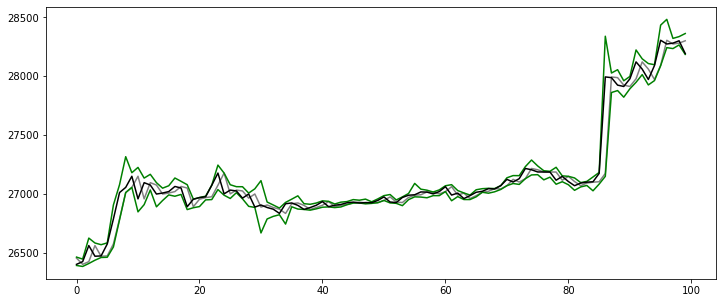

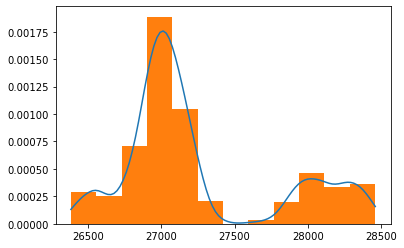

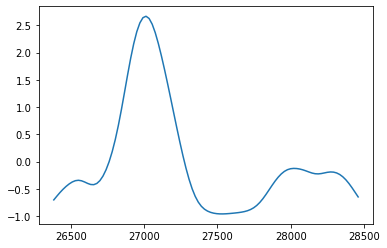

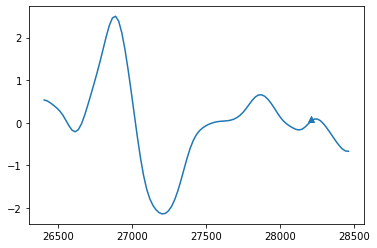

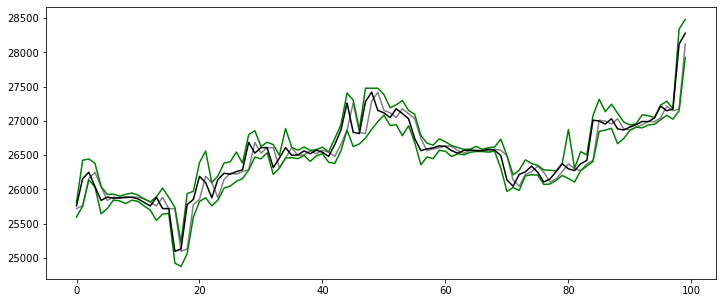

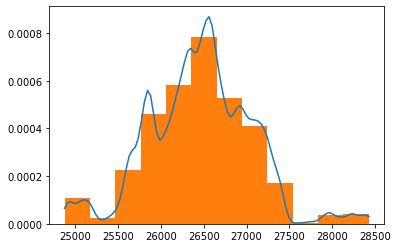

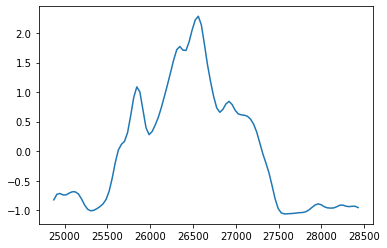

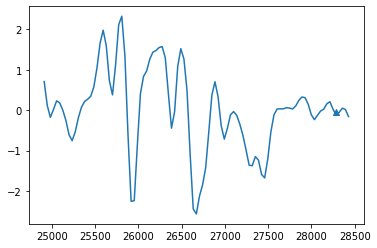

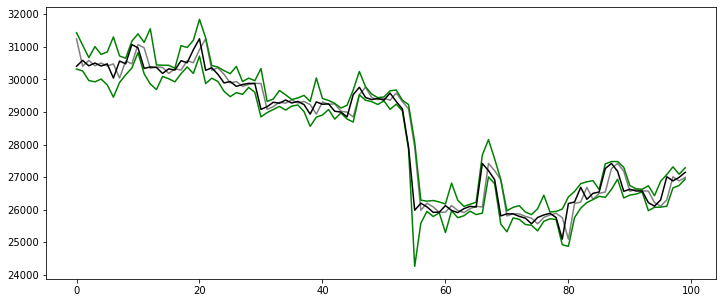

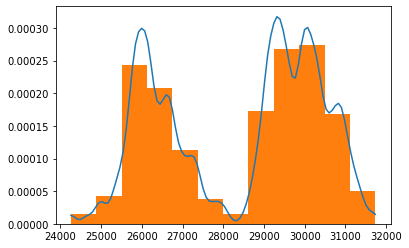

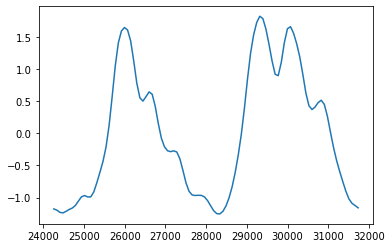

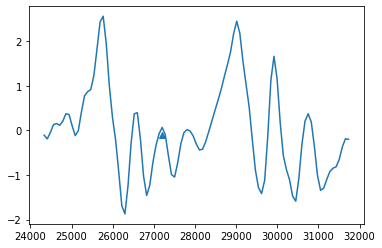

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
%matplotlib inline

for period in supported_period.keys():
    
    # 데이터 Pandas 변환
    datas_ = datas[period][0]
    datas_ = pd.DataFrame(datas_, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])
    
    # 거래량 multiple 계산 방식 구현
    volume_profiles = []
    
    for i in range(len(datas_['time'])):
        volume = datas_['volume'][i]
        open_price = datas_['open'][i]
        high_price = datas_['high'][i]
        low_price = datas_['low'][i]
        close_price = datas_['close'][i]
        center_price = (open_price + high_price + low_price + close_price) / 4
        
        total_div = 10
        div_size = (high_price - low_price) / total_div
        index_pivot = (center_price - low_price) // div_size
        index_pivot = max(min(index_pivot, total_div - 1), 1) # 시고저종 가격을 바탕으로 중심값 선정
        multiple_of_volume = np.array(list(np.linspace(1, 0, int(index_pivot))) \
                                    + list(np.linspace(0, 1, int(total_div - index_pivot + 1))[1:]))
        multiple_of_volume /= sum(multiple_of_volume)
        
        for j in range(len(multiple_of_volume)):
            for k in range(int(volume * multiple_of_volume[j] / total_div)):
                volume_profiles.append(low_price + j * div_size)

    # 주가 그래프 그리기
    plt.figure(figsize=(12,5))
    plt.plot(datas_['open'], 'gray')
    plt.plot(datas_['high'], 'green')
    plt.plot(datas_['low'], 'green')
    plt.plot(datas_['close'], 'black')
    plt.show()
    
    # KDE 적용
    level = 100
    x = np.linspace(min(volume_profiles) - 1, max(volume_profiles) + 1, level)
    kde = gaussian_kde(volume_profiles)
    plt.plot(x, kde(x), label='KDE')
    plt.hist(volume_profiles, density=True, bins=12)
    plt.show()
    
    # KDE 정규화 적용
    kdes = []
    
    for i in range(len(x)):
        kdes.append(kde(x[i]))
    
    kdes = np.array(kdes)
    kdes -= np.mean(kdes)
    kdes /= np.std(kdes)
    
    plt.plot(x, kdes, label='KDE Normalization')
    plt.show()
    
    # 미분 적용
    kdes_diff = []

    for i in range(1, len(x)):
        kdes_diff.append(kde(x[i]) - kde(x[i-1]))
    
    kdes_diff = np.array(kdes_diff)
    kdes_diff -= np.mean(kdes_diff)
    kdes_diff /= np.std(kdes_diff)
    
    plt.plot(x[1:], kdes_diff, label='KDE Differential')
    
    # 현재 가격에 대한 plot 적용
    now_close = datas_['close'].iloc[-1]
    for idx, i in enumerate(x):
        if now_close <= i:
            plt.scatter(i, kdes_diff[idx], marker='^')
            break
    
    
    plt.show()
    

# 1H
rsi14
95    80.257496
96    78.158440
97    78.299637
98    78.705795
99    70.941318
Name: rsi14, dtype: float64
rsi14_ma
95    73.762261
96    75.671937
97    77.524144
98    79.370983
99    80.083481
Name: rsi14_ma, dtype: float64


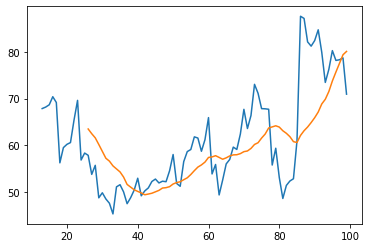

macd
95    286.495657
96    295.465265
97    299.707344
98    301.209883
99    290.294663
Name: macd, dtype: float64
macd_ma
95    231.347627
96    247.876729
97    261.162948
98    272.036103
99    279.355207
Name: macd_ma, dtype: float64


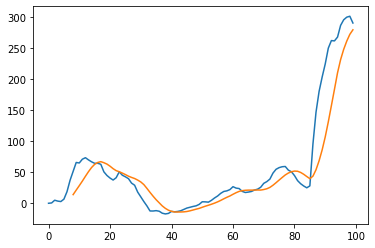

macd_gc_prob
95    0.464763
96    0.401055
97    0.324835
98    0.245864
99    0.092193
Name: macd_gc_prob, dtype: float64


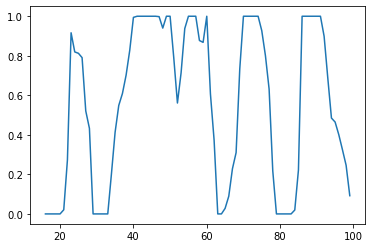

# 6H
rsi14
95    69.773226
96    65.961289
97    66.696798
98    82.209276
99    83.593117
Name: rsi14, dtype: float64
rsi14_ma
95    62.168654
96    63.399198
97    64.534967
98    65.590591
99    66.782404
Name: rsi14_ma, dtype: float64


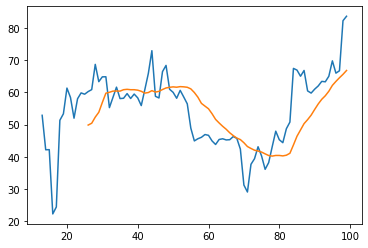

macd
95    161.260183
96    167.255890
97    172.064387
98    249.460161
99    319.964796
Name: macd, dtype: float64
macd_ma
95    126.297442
96    134.328576
97    141.654952
98    156.888860
99    179.182133
Name: macd_ma, dtype: float64


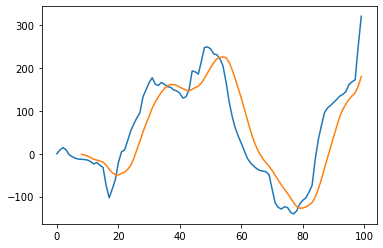

macd_gc_prob
95    0.269387
96    0.283417
97    0.310696
98    1.000000
99    1.000000
Name: macd_gc_prob, dtype: float64


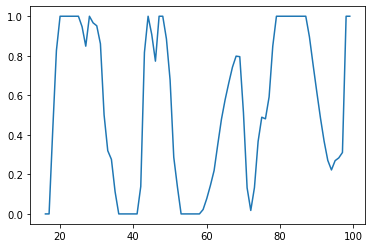

# 1D
rsi14
95    46.562320
96    55.924852
97    54.100494
98    55.434364
99    57.359614
Name: rsi14, dtype: float64
rsi14_ma
95    50.969527
96    51.185142
97    51.584550
98    51.922084
99    52.361701
Name: rsi14_ma, dtype: float64


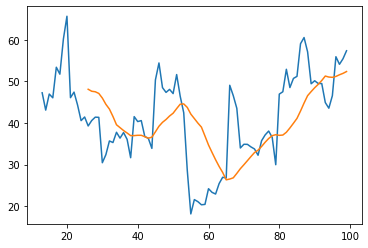

macd
95   -60.495185
96   -11.699643
97    16.537512
98    47.099435
99    82.954212
Name: macd, dtype: float64
macd_ma
95    0.302343
96    0.305877
97   -2.296061
98   -0.531468
99    5.474205
Name: macd_ma, dtype: float64


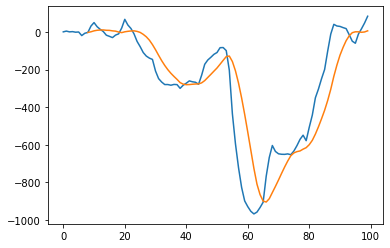

macd_gc_prob
95    0.000000
96    0.144805
97    0.296687
98    0.507265
99    0.832996
Name: macd_gc_prob, dtype: float64


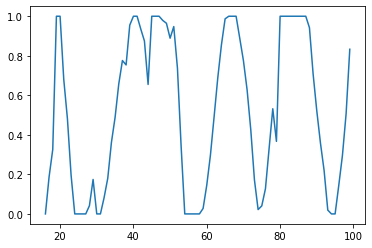

In [7]:
# RSI 보조지표 계산
for period in supported_period.keys():
    datas_ = datas[period][0]
    datas_ = pd.DataFrame(datas_, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])
    
    # 상승과 하락에 대한 차이 계산
    datas_['price_diff'] = datas_['close'].diff()
    
    # 양수(상승)와 음수(하락)를 구분하는 열 추가
    datas_['gain'] = datas_['price_diff'].apply(lambda x: x if x > 0 else 0)
    datas_['loss'] = datas_['price_diff'].apply(lambda x: -x if x < 0 else 0)
    
    # 이동평균 계산 (14일 기간)
    p = 14
    datas_['au'] = datas_['gain'].ewm(com=p-1, min_periods=p).mean()
    datas_['ad'] = datas_['loss'].ewm(com=p-1, min_periods=p).mean()
    datas_['rs'] = datas_['au'] / datas_['ad']
    
    # 상대강도지수 계산 (RSI)
    datas_['rsi14'] = 100 - (100 / (1 + datas_['rs']))
    
    # 14일 동안의 rsi14 에 대한 평균선 계산
    datas_['rsi14_ma'] = datas_['rsi14'].rolling(window=14).mean()
    
    # 단기(12일) 이동평균 계산
    datas_['ema12'] = datas_['close'].ewm(span=12).mean()

    # 장기(26일) 이동평균 계산
    datas_['ema26'] = datas_['close'].ewm(span=26).mean()

    # MACD 계산
    datas_['macd'] = datas_['ema12'] - datas_['ema26']
    
    # 9일 동안의 macd 에 대한 평균선 계산
    datas_['macd_ma'] = datas_['macd'].rolling(window=9).mean()
    
    # MACD Osillator 계산
    datas_['macd_oscillator'] = datas_['macd'] - datas_['macd_ma']
    
    # MACD Osillator 골든크로스 확률 계산 (대략적인)
    datas_['macd_min'] = datas_['macd_oscillator'].rolling(window=9).min()
    datas_.loc[datas_['macd_min'] > 0, 'macd_min'] = 0
    datas_['macd_max'] = datas_['macd_oscillator'].rolling(window=9).max()
    datas_.loc[datas_['macd_max'] < 0, 'macd_max'] = 0
    
    datas_['macd_gc_prob'] = (datas_['macd_oscillator'] - datas_['macd_min']) \
                           / (datas_['macd_max'] - datas_['macd_min'])
    
    # 필요 없는 열 삭제
    datas_.drop(['price_diff', 'gain', 'loss', 'au', 'ad', 'rs', 'macd_oscillator', 'macd_min', 'macd_max'], axis=1, inplace=True)

    print("#", period)
    print("rsi14")
    print(datas_["rsi14"].iloc[-5:])
    print("rsi14_ma")
    print(datas_["rsi14_ma"].iloc[-5:])
    plt.plot(datas_["rsi14"])
    plt.plot(datas_["rsi14_ma"])
    plt.show()
    
    print("macd")
    print(datas_["macd"].iloc[-5:])
    print("macd_ma")
    print(datas_["macd_ma"].iloc[-5:])
    plt.plot(datas_["macd"])
    plt.plot(datas_["macd_ma"])
    plt.show()
    
    print("macd_gc_prob")
    print(datas_["macd_gc_prob"].iloc[-5:])
    plt.plot(datas_["macd_gc_prob"])
    plt.show()
